# 第七章 K近邻算法

# 1.K近邻算法葡萄酒数据集预测

In [1]:
#from pyspark.ml.regression import KNNRegressionModel
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.feature import StandardScaler
from pyspark.mllib.regression import LabeledPoint
#from pyspark.mllib.classification import KNNClassificationModel, KNNModel
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql import SparkSession
import os
from pyspark.ml.feature import *
from pyspark.ml.classification import *
from pyspark.sql.functions import concat, array, col
from pyspark.sql.types import DoubleType
from pyspark.ml.linalg import Vectors
#from pyspark.ml.classification import KNNClassifier

In [2]:
import numpy as np
import pandas as pd
import math

In [3]:
# create a spark session
spark = SparkSession.builder.appName("KMeans").getOrCreate()

# load the data
data = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("葡萄酒.csv")
data.show()


+--------+-----------+-------------+----+
|原始样本|酒精含量(%)|苹果酸含量(%)|分类|
+--------+-----------+-------------+----+
|   样本1|          5|            2|   0|
|   样本2|          6|            1|   0|
|   样本3|          4|            1|   0|
|   样本4|          8|            3|   1|
|   样本5|         10|            2|   1|
+--------+-----------+-------------+----+



In [4]:
#强制类型转化，避免assembler中两特征值类型不同
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType

data = data.withColumn("酒精含量(%)", col("酒精含量(%)").cast(DoubleType()))
data = data.withColumn("苹果酸含量(%)", col("苹果酸含量(%)").cast(DoubleType()))

data.show()

+--------+-----------+-------------+----+
|原始样本|酒精含量(%)|苹果酸含量(%)|分类|
+--------+-----------+-------------+----+
|   样本1|        5.0|          2.0|   0|
|   样本2|        6.0|          1.0|   0|
|   样本3|        4.0|          1.0|   0|
|   样本4|        8.0|          3.0|   1|
|   样本5|       10.0|          2.0|   1|
+--------+-----------+-------------+----+



In [5]:
# 生成特征向量
assembler = VectorAssembler(inputCols=["酒精含量(%)","苹果酸含量(%)"], outputCol="features")

data = assembler.transform(data)

data.show()

+--------+-----------+-------------+----+----------+
|原始样本|酒精含量(%)|苹果酸含量(%)|分类|  features|
+--------+-----------+-------------+----+----------+
|   样本1|        5.0|          2.0|   0| [5.0,2.0]|
|   样本2|        6.0|          1.0|   0| [6.0,1.0]|
|   样本3|        4.0|          1.0|   0| [4.0,1.0]|
|   样本4|        8.0|          3.0|   1| [8.0,3.0]|
|   样本5|       10.0|          2.0|   1|[10.0,2.0]|
+--------+-----------+-------------+----+----------+



In [6]:
# 训练KNN模型
kmeans = KMeans().setK(2).setSeed(1)
model = kmeans.fit(data)

In [7]:
# 预测单个样本
new_data1 = [(7,1)]
test1 = spark.createDataFrame(new_data1,["酒精含量(%)","苹果酸含量(%)"])
test1 = assembler.transform(test1)
predictions = model.transform(test1)
predictions.show()

+-----------+-------------+---------+----------+
|酒精含量(%)|苹果酸含量(%)| features|prediction|
+-----------+-------------+---------+----------+
|          7|            1|[7.0,1.0]|         0|
+-----------+-------------+---------+----------+



In [8]:
#预测多个样本
new_data2 = [(7,1),(8,3)]
test2 = spark.createDataFrame(new_data2,["酒精含量(%)","苹果酸含量(%)"])
test2 = assembler.transform(test2)
predictions = model.transform(test2)
predictions.show()

+-----------+-------------+---------+----------+
|酒精含量(%)|苹果酸含量(%)| features|prediction|
+-----------+-------------+---------+----------+
|          7|            1|[7.0,1.0]|         0|
|          8|            3|[8.0,3.0]|         1|
+-----------+-------------+---------+----------+



# 2.数据归一化代码演示

2.1 min-max标准化

In [9]:
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.linalg import Vectors

In [10]:
# create a spark session
spark = SparkSession.builder.appName("Min-Max").getOrCreate()
# Create a DataFrame with some sample data
data = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("葡萄酒2.csv")
data.show()

+--------+-----------+-------------+----+
|原始样本|酒精含量(%)|苹果酸含量(%)|分类|
+--------+-----------+-------------+----+
|   样本1|         50|            2|   0|
|   样本2|         60|            1|   0|
|   样本3|         40|            1|   0|
|   样本4|         80|            3|   1|
|   样本5|        100|            2|   1|
+--------+-----------+-------------+----+



In [11]:
data = data.withColumn("酒精含量(%)", col("酒精含量(%)").cast(DoubleType()))
data = data.withColumn("苹果酸含量(%)", col("苹果酸含量(%)").cast(DoubleType()))

data.show()

+--------+-----------+-------------+----+
|原始样本|酒精含量(%)|苹果酸含量(%)|分类|
+--------+-----------+-------------+----+
|   样本1|       50.0|          2.0|   0|
|   样本2|       60.0|          1.0|   0|
|   样本3|       40.0|          1.0|   0|
|   样本4|       80.0|          3.0|   1|
|   样本5|      100.0|          2.0|   1|
+--------+-----------+-------------+----+



In [12]:
# 生成特征向量
assembler = VectorAssembler(inputCols=["酒精含量(%)","苹果酸含量(%)"], outputCol="features")

data = assembler.transform(data)

data.show()

+--------+-----------+-------------+----+-----------+
|原始样本|酒精含量(%)|苹果酸含量(%)|分类|   features|
+--------+-----------+-------------+----+-----------+
|   样本1|       50.0|          2.0|   0| [50.0,2.0]|
|   样本2|       60.0|          1.0|   0| [60.0,1.0]|
|   样本3|       40.0|          1.0|   0| [40.0,1.0]|
|   样本4|       80.0|          3.0|   1| [80.0,3.0]|
|   样本5|      100.0|          2.0|   1|[100.0,2.0]|
+--------+-----------+-------------+----+-----------+



In [13]:
# Create a MinMaxScaler object
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")

# Fit the scaler to the data
scalerModel = scaler.fit(data)

# Transform the data using the scaler
scaledData = scalerModel.transform(data)

# Show the scaled data
scaledData.select("scaledFeatures").head(5)

[Row(scaledFeatures=DenseVector([0.1667, 0.5])),
 Row(scaledFeatures=DenseVector([0.3333, 0.0])),
 Row(scaledFeatures=DenseVector([0.0, 0.0])),
 Row(scaledFeatures=DenseVector([0.6667, 1.0])),
 Row(scaledFeatures=DenseVector([1.0, 0.5]))]

2.2 Z-score标准化

In [14]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.linalg import Vectors

In [15]:
# Create a StandardScaler object
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)

# Fit the scaler to the data
scalerModel = scaler.fit(data)

# Transform the data using the scaler
scaledData = scalerModel.transform(data)

# scaledData = scaler.fit(data).transform(data)
# Show the scaled data
#scaledData.show()
scaledData.select("scaledFeatures").head(5)
# scalerModel.mean, scalerModel.std

[Row(scaledFeatures=DenseVector([-0.6644, 0.239])),
 Row(scaledFeatures=DenseVector([-0.2491, -0.9562])),
 Row(scaledFeatures=DenseVector([-1.0796, -0.9562])),
 Row(scaledFeatures=DenseVector([0.5813, 1.4343])),
 Row(scaledFeatures=DenseVector([1.4118, 0.239]))]

因为原数据并非正态分布，故z-score标准化需要设置参数withMean=True, withStd=True

当标准化结果不理想时，可以对原始数据进行一些预处理，例如去除异常值或进行平滑处理，也可以尝试使用其他的机器学习算法，例如决策树或者支持向量机等。

由上述结果可以看出，此处的标准化结果与所给样例不同，猜想是因为sklearn库与StandardScaler标准差使用的公式不同。   

在sklearn中公式如下：   
$$\sigma = \sqrt{\frac{1}{N}\sum_{i=1}^{N}(x_i-\mu)^2}$$
但在StandardScaler方法中为：  
$$\sigma = \sqrt{\frac{1}{N-1}\sum_{i=1}^{N}(x_i-\mu)^2}$$


# 3.案例实战 - 手写数字识别模型

由于mlib中并未实现KNN方法，故使用KMeans进行替代

In [16]:
spark = SparkSession.builder.appName("HandWriting").getOrCreate()

# 1.读取数据
data = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("手写字体识别.csv")
#data.head()

In [17]:
assembler = VectorAssembler(inputCols=list(data.columns[1:]), outputCol="features")
data = assembler.transform(data)

#手动生成特征向量：
# columns_connect = [str(i) for i in range(1, 1024)]
# data = data.select(*(col(c).cast("double").alias(c) for c in data.columns))
# data = data.withColumn("features", array(*columns_connect))

data = data.select("对应数字","features").dropna()
#data.select("features").head()

In [18]:
# 3.划分训练集与测试集
(trainingData, testData) = data.randomSplit([0.8, 0.2])

In [19]:
trainingData.show()

+--------+--------------------+
|对应数字|            features|
+--------+--------------------+
|       0|(1024,[8,9,10,11,...|
|       0|(1024,[9,10,11,12...|
|       0|(1024,[10,11,12,1...|
|       0|(1024,[10,11,12,1...|
|       0|(1024,[10,11,12,1...|
|       0|(1024,[10,11,12,4...|
|       0|(1024,[10,11,41,4...|
|       0|(1024,[10,11,42,4...|
|       0|(1024,[10,15,16,1...|
|       0|(1024,[10,19,20,4...|
|       0|(1024,[11,12,13,1...|
|       0|(1024,[11,12,13,1...|
|       0|(1024,[11,12,13,1...|
|       0|(1024,[11,12,13,1...|
|       0|(1024,[11,12,13,1...|
|       0|(1024,[11,12,13,1...|
|       0|(1024,[11,12,13,1...|
|       0|(1024,[11,12,13,1...|
|       0|(1024,[11,12,13,1...|
|       0|(1024,[11,12,13,1...|
+--------+--------------------+
only showing top 20 rows



In [26]:
# 4.训练KNN模型
#由于是聚类方法，因此K必须为10类
kmeans = KMeans().setK(10).setSeed(6)
model = kmeans.fit(trainingData)

In [27]:
#5.预测测试数据集结果
from pyspark.sql.functions import concat_ws
predictions = model.transform(trainingData)

# predictions = predictions.select(col("对应数字","prediction").cast("string"))
# predictions.write.format("text").save("数字对应分类")

predictions = predictions.withColumn("selected_columns", concat_ws(",", *[col(c) for c in ["对应数字","prediction"]]))
predictions.select("selected_columns").write.format("text").save("数字对应分类2")

# predictions.show()

将训练结果进行打印，得到每个数字对应的分类如下：  

| 对应数字 | 聚类结果 |
| -------- | -------- |
| 0 | 4 |
| 1 | 3 |
| 2 | 2 | 
| 3 | 1 |
| 4 | 0 |
| 5 | 9 | 
| 6 | 8 | 
| 7 | 6 |
| 8 | 5 |
| 9 | 7 |

In [28]:
#predictions.show()
#6.对测试集进行训练
predictions = model.transform(testData)

In [29]:
#对比预测结果
predictions.select("对应数字","prediction").head(5)

[Row(对应数字=0, prediction=5),
 Row(对应数字=0, prediction=5),
 Row(对应数字=0, prediction=5),
 Row(对应数字=0, prediction=5),
 Row(对应数字=0, prediction=5)]

In [30]:
#7.对预测准确度进行评估

#各数字
predictions.groupBy("对应数字").count().show()
predictions.groupBy("对应数字","prediction").count().show(100)

+--------+-----+
|对应数字|count|
+--------+-----+
|       1|   48|
|       6|   35|
|       3|   31|
|       5|   33|
|       9|   45|
|       4|   34|
|       8|   34|
|       7|   34|
|       2|   37|
|       0|   50|
+--------+-----+

+--------+----------+-----+
|对应数字|prediction|count|
+--------+----------+-----+
|       3|         1|   29|
|       2|         2|   35|
|       8|         9|   12|
|       9|         4|    5|
|       8|         3|   14|
|       1|         7|    2|
|       1|         2|    1|
|       4|         0|   22|
|       0|         5|   49|
|       5|         7|    6|
|       6|         8|   35|
|       4|         9|    1|
|       9|         7|   36|
|       1|         3|   30|
|       0|         0|    1|
|       1|         4|   15|
|       8|         1|    1|
|       4|         3|    1|
|       2|         1|    1|
|       4|         6|    3|
|       8|         7|    6|
|       8|         2|    1|
|       3|         9|    1|
|       5|         1|    1|
|       9|   

由各数字在测试集中出现次数与聚类结果进行比对，正确率计算如下：

In [31]:
accuracy = (49+30+35+29+22+26+35+34+12+36)/(51+42+42+34+36+36+36+33+32+44)
print("Test accuracy = %g" % accuracy)

Test accuracy = 0.797927


# 4.补充知识点：图像识别原理详解

4.1 图片大小调整及显示

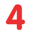

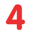

In [32]:
from PIL import Image
img = Image.open('数字4.png')
img = img.resize((32,32))
img.show()
img

4.2 图片灰度处理

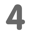

In [33]:
img = img.convert('L')
img

4.3 图片二值化处理

In [34]:
# 二值化处理
import numpy as np
img_new = img.point(lambda x: 0 if x > 128 else 1)
arr = np.array(img_new)

# 打印arr中的每一行
for i in range(arr.shape[0]):
    print(arr[i])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0

4.4 二维数组转一维数组

In [35]:
arr_new = arr.reshape(1, -1)
arr_new

array([[0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [36]:
print(arr_new.shape)

(1, 1024)


此时我们可以把这个处理过的图片“数字4”传入到我们上面训练好的KMeans模型中

In [37]:
spark = SparkSession.builder.appName("array_to_dataframe").getOrCreate()

# assembler = VectorAssembler(inputCols=arr_new[:], outputCol="features")
# arr_new = assembler.transform(arr_new)

# import pandas as pd
test_data = [(Vectors.dense(arr_new[0]),)]
test_df = spark.createDataFrame(test_data, ["features"])
predictions = model.transform(test_df)
#print('图片中的数字为：' + str(answer[0]))

In [38]:
predictions.select("prediction").head()

Row(prediction=0)

经过比对，发现0聚类对应的数字为4，因此分类正确